In [2]:
import sys

sys.path.append(os.path.join(os.getcwd(), 'Mrlishu'))
if os.path.exists('/content'):
    os.chdir('/content')
    CODE_DIR = 'PHM-Tongji'
    if not os.path.exists(CODE_DIR):
        !git clone https://github.com/MrLishu/PHM-Tongji.git $CODE_DIR
    os.chdir(f'./{CODE_DIR}')

In [3]:
import os
import numpy as np
import pandas as pd
import pywt

from utils import *

# 预处理数据

读取CSV数据

可以调整`dataframe_number`以避免每次都读取所有数据

如果处理C1的全部315个表，这个过程大概需要1min

In [4]:
data_directory = r'data/raw/PHM2010/c1'
dataframe_number = 315  # max=315
signal_name = ['Fx', 'Fy', 'Fz', 'Ax', 'Ay', 'Az', 'AE_rms']
sampling_rate = 5000

raw_dataset = []
for i in range(dataframe_number):
    df = pd.read_csv(os.path.join(data_directory, f'c_1_{i + 1:03d}.csv'), names=signal_name)
    raw_dataset.append(df)
    print(f'\rLoading data... ({i + 1}/{dataframe_number})', end='')
print(f'\nData loading completed.')

Loading data... (5/315)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

第一个 DataFrame 的简要信息

In [ ]:
raw_dataset[0].describe()

对每一个表中的六个信号，
以一定的间隔截取其信号最中间一段的1024个样本点

然后进行连续小波变换`pywt.cwt`，
然后将结果储存在`cwt_dataset`中

`resample_dataset`中储存的是重采样后的信号

先设定重采样和小波变换的参数

In [8]:
resample_number = 1024
step = 1

totalscale = 256
wavename = 'morl'

fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscale
scales = cparam / np.arange(totalscale, 0, -1)

进行重采样和小波变换

这个过程大概需要1min

In [9]:
print('Preprocessing data...')
resample_dataset = np.empty((dataframe_number, len(signal_name), resample_number))
cwt_dataset = np.empty((dataframe_number, len(signal_name), totalscale, resample_number))

for i, df in enumerate(raw_dataset):
    data = df.to_numpy().T
    data -= data.mean(axis=-1)[:, np.newaxis]
    data /= data.std(axis=-1)[:, np.newaxis]
    sample_number = data.shape[1]
    data = data[:, (sample_number - resample_number * step) // 2:(sample_number + resample_number * step) // 2:step]
    cwtmatr, frequencies = pywt.cwt(data, scales, wavename, 1 / (sampling_rate / step))

    resample_dataset[i] = data
    cwt_dataset[i] = cwtmatr.transpose(1, 0, 2)
    print(f'\rContinuous wavelet transform... ({i + 1}/{dataframe_number})', end='')
print(f'\nContinuous wavelet transform completed.')

Preprocessing data...
Continuous wavelet transform... (3/3)
Continuous wavelet transform completed.


展示最后一个表中第一个信号（Fx）的小波变换效果图

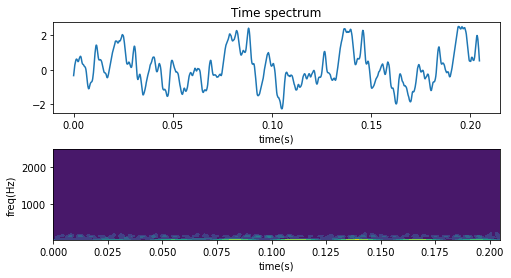

In [16]:
i, j = -1, 0
signal = resample_dataset[i][j]
cwtmatr = cwt_dataset[i][j]
plotCwt(sampling_rate / step, signal, cwtmatr, frequencies)

读取标签数据

In [5]:
label_path = r'data/raw/PHM2010/c1_wear.csv'
label_dataset = pd.read_csv((label_path))
print(label_dataset.info())

label_dataset = label_dataset.to_numpy()
label_dataset = label_dataset[:dataframe_number]

np.save(r'data/processed/PHM2010/c1_label.npy', label_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cut      315 non-null    int64  
 1   flute_1  315 non-null    float64
 2   flute_2  315 non-null    float64
 3   flute_3  315 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 10.0 KB
None


# 训练模型

## 准备训练数据

In [15]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(cwt_dataset, label_dataset, test_size=0.1, random_state=99)
train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [ ]:
data, label = next(iter(train_dataloader))
data, label

In [19]:
model = models.resnet18()
model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
model

ResNet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):